# Unimodality

In [1]:
%matplotlib inline
import numpy as np
import pylab as plt

from scipy.stats import norm, t as tdist

from scipy.integrate import quad, dblquad

import GPy

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important;align=center; }</style>"))
np.set_printoptions(precision=4, linewidth=200)

import seaborn as snb
snb.set_style('darkgrid')
snb.set(font_scale = 1.5)

np.random.seed(0)

### Helper functions

In [2]:
def plot_with_uncertainty(x, y, ystd=None, color='r', linestyle='-', fill=True, label=''):
    plt.plot(x, y, color=color, linestyle=linestyle, label=label)
    if not ystd is None:
        lower, upper = y - np.sqrt(ystd), y + np.sqrt(ystd)
        plt.plot(x, lower, color=color, alpha=0.5, linestyle=linestyle)
        plt.plot(x, upper, color=color, alpha=0.5, linestyle=linestyle)
        
        if fill:
            plt.fill_between(x.ravel(), lower, upper, color=color, alpha=0.25, linestyle=linestyle)

### Generate test data sets

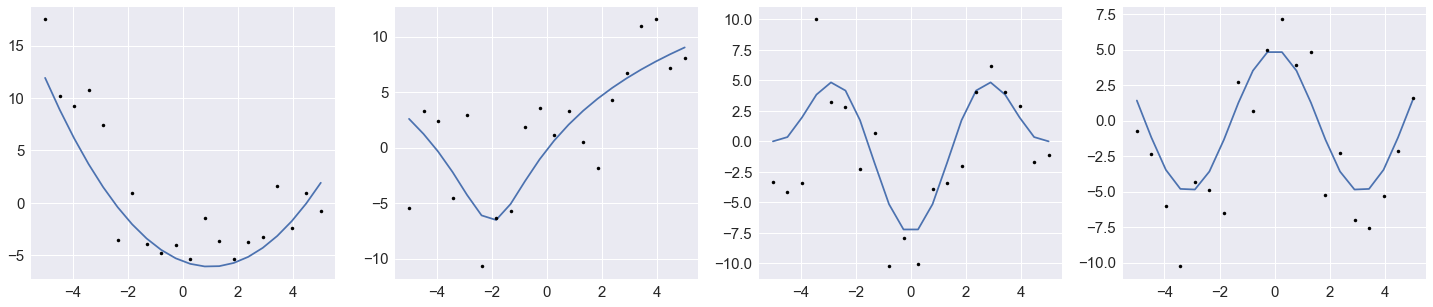

In [3]:
fs = [lambda x: -norm.logpdf(x-1, 0, 1) - 7, lambda x: -4*(tdist.logpdf(x+2, 1) + 2.8), lambda x: 0.3*(x**2 - 25)*np.sin(x+0.5*np.pi), lambda x: 5*np.sin(x+0.5*np.pi)]

sigma2 = 10.

k1, k2 = 5., 2.

N = 20
M = 20
t = np.linspace(-5, 5, N)[:, None]
t2 = np.linspace(-5, 5, M)[:, None]
ys = [f(t) + np.random.normal(0, np.sqrt(sigma2), size=(N, 1)) for f in fs]

plt.figure(figsize = (25, 5))
for idx, (y, f) in enumerate(zip(ys, fs)):
    plt.subplot(1, len(fs), 1 + idx)
    plt.plot(t, f(t))
    plt.plot(t, y, 'k.')

### Run EP

In [4]:
def generate_joint_derivative_kernel(t, t2, k1, k2, jitter = 1e-8):

    assert(t.ndim == 2), "Wrong dimensions for t"
    assert(t2.ndim == 2), "Wrong dimensions for t"

    # kernel functions
    cov_fun, cov_fun1, cov_fun2 = lambda x, y: k1**2*np.exp(-0.5*(x-y)**2/k2**2), lambda x, y: -cov_fun(x,y)*(x-y)/k2**2, lambda x, y: cov_fun(x,y)*(1 - (x-y)**2/k2**2 )/k2**2

    # Prepare for joint kernel
    N, M = t.shape[0], t2.shape[0]
    K = np.zeros((N + M, N + M))

    # Kernel for regular observations and derivative observations
    K[:N, :N] = cov_fun(t, t.T)
    K[N:, N:] = cov_fun2(t2, t2.T)

    # Kernel for covariance between reg. and der. observations
    K[N:, :N] = cov_fun1(t2, t.T)
    K[:N, N:] = K[N:, :N].T

    # jitter
    K += jitter*np.identity(N + M)

    return K

def update_posterior(K, eta, theta):
    D = K.shape[0]
    sqrt_theta = np.sqrt(theta)
    G = sqrt_theta[:, None]*K
    B = np.identity(D) + G*sqrt_theta
    L = np.linalg.cholesky(B)
    V = np.linalg.solve(L, G)
    Sigma_full = K - np.dot(V.T, V)
    mu, Sigma = np.dot(Sigma_full, eta), np.diag(Sigma_full)

    return mu, Sigma, Sigma_full, L

npdf = lambda x, m, v: 1./np.sqrt(2*np.pi*v)*np.exp(-(x-m)**2/(2*v))
log_npdf = lambda x, m, v: -0.5*np.log(2*np.pi*v) -(x-m)**2/(2*v)
phi = lambda x: norm.cdf(x)
logphi = lambda x: norm.logcdf(x)

$\begin{align}
p(\mathbf{y}, \mathbf{f}, \mathbf{f}', \mathbf{z}, \mathbf{g}, \mathbf{g}', \mathbf{m}) = \frac{1}{Z}\mathcal{N}\left(\textbf{y}|\mathbf{f}, \sigma^2 \mathbf{I}\right)p(\mathbf{f}, \mathbf{f}')\prod_{i=1}^M \phi\left(z_if_i'\right)\prod_{i=1}^M \text{Ber}\left(z_i|\phi\left(g_i\right)\right)  p(\mathbf{g}, \mathbf{g}')\prod_{i=1}^M \phi\left(m_i g_i'\right) 
\end{align}$,

where $m$ is  the set of gradient observations for g, and  $z \in \left\lbrace-1, 1\right\rbrace$ is  the set of gradient observations.

Re-write

$\begin{align}
p(\mathbf{y}, \mathbf{f}, \mathbf{f}', \mathbf{z}, \mathbf{g}, \mathbf{g}', \mathbf{m}) = \frac{1}{Z}\mathcal{N}\left(\textbf{y}|\mathbf{f}, \sigma^2 \mathbf{I}\right)p(\mathbf{f}, \mathbf{f}')\prod_{i=1}^M \phi\left(z_if_i'\right) \text{Ber}\left(z_i|\phi\left(g_i\right)\right)  p(\mathbf{g}, \mathbf{g}')\prod_{i=1}^M \phi\left(m_i g_i'\right) 
\end{align}$,

Marginalize wrt. $\mathbf{z}$

$\begin{align}
p(\mathbf{y}, \mathbf{f}, \mathbf{f}', \mathbf{g}, \mathbf{g}', \mathbf{m}) = \sum_{\mathbf{z}}\frac{1}{Z}\mathcal{N}\left(\textbf{y}|\mathbf{f}, \sigma^2 \mathbf{I}\right)p(\mathbf{f}, \mathbf{f}')\prod_{i=1}^M \phi\left(z_if_i'\right) \text{Ber}\left(z_i|\phi\left(g_i\right)\right)  p(\mathbf{g}, \mathbf{g}')\prod_{i=1}^M \phi\left(m_i g_i'\right) 
\end{align}$,


### The approximation

In [5]:
def ep_unimodality(t, y, t2, m=None, max_itt=50, nu=10., alpha=0.9, tol=1e-4, verbose=0):
    
    N, M = len(t), len(t2)
    Df = N + M
    Dg = M + M

    if m is None:
        m = np.ones(M)

    # sites for likelihood 
    eta_y, theta_y = np.zeros(Df), np.zeros(Df)
    eta_y[:N], theta_y[:N] = y[:, 0]/sigma2, 1./sigma2

    # sites connecting f' and g
    eta_fp, theta_fp = np.zeros(Dg), 1e-10*np.ones(Dg)
    eta_g, theta_g = np.zeros(Dg), 1e-10*np.ones(Dg)

    # sites for g' and m
    eta_gp, theta_gp = np.zeros(Dg), 1e-10*np.ones(Dg)

    # prepare kernels
    Kf = generate_joint_derivative_kernel(t, t2, k1, k2)
    Kg = generate_joint_derivative_kernel(t, t2, k1, k2)

    # prepare global approximation
    mu_f, Sigma_f, Sigma_full_f, Lf = update_posterior(Kf, eta_fp + eta_y, theta_fp + theta_y)
    mu_g, Sigma_g, Sigma_full_g, Lg = update_posterior(Kg, eta_gp, theta_gp)

    for itt in range(max_itt):

        if verbose > 0:
            print('Iteration %d' % (itt + 1))

        # approximate constraints to enforce monotonicity to g
        for j in np.random.choice(range(M), size=M, replace=False):

            # compute offset for gradient indices
            i = M + j

            # compute cavity
            eta_cav, theta_cav = mu_g[i]/Sigma_g[i] - eta_gp[j], 1./Sigma_g[i] - theta_gp[j]
            m_cav, v_cav = eta_cav/theta_cav, 1./theta_cav

            if v_cav <= 0:
                print('EP: Negative cavity observed at site %d in iteration %d, skipping update' % (j, itt + 1))
                continue

            # Compute moments
            #tilted = lambda x: phi(m[j]*nu*x)*npdf(x, m_cav, v_cav)
            #lower, upper = m_cav - 6*np.sqrt(v_cav), m_cav + 6*np.sqrt(v_cav)
            #Z = quad(tilted, lower, upper)[0]

            #site_m = quad(lambda x: x*tilted(x), lower, upper)[0]/Z
            #site_m2 = quad(lambda x: x**2*tilted(x), lower, upper)[0]/Z

            s = m[j]
            mean, variance = s*nu*m_cav, (s*nu)**2*v_cav
            z = mean/np.sqrt(1 + variance)

            # Normalization            
            Z = phi(z)

            # First moment
            qs = Z*m_cav + s*nu*v_cav*npdf(z, 0, 1)/np.sqrt(1 + variance)
            site_m = qs/Z

            # Second moment
            d, b = s*nu*v_cav*npdf(z, 0, 1)/(Z*np.sqrt(1 + variance)), (s*nu)**2*v_cav**2*z*npdf(z, 0, 1)/(Z*(1 + variance))
            q2s = Z*(2*m_cav*(m_cav + d) + v_cav - m_cav**2 - b)
            site_m2 = q2s/Z

            # variance
            site_v = site_m2 - site_m**2

            new_eta = site_m/site_v - eta_cav
            new_theta = 1./site_v - theta_cav

            if new_theta < 0:
                new_theta = 1e-10
                new_variance = 1./(new_theta + theta_cav)
                new_eta = site_m/new_variance - eta_cav

            # update site
            eta_gp[i], theta_gp[i] = (1-alpha)*eta_gp[i] + alpha*new_eta, (1-alpha)*theta_gp[i] + alpha*new_theta

            # update joint
            mu_g, Sigma_g, Sigma_full_g, Lg = update_posterior(Kg, eta_g + eta_gp, theta_g + theta_gp)


        # approximate constraints to enforce a single sign change for f'
        for j in np.random.choice(range(M), size = M, replace=False):

            i = N + j

            # compute cavity
            eta_cav_fp, theta_cav_fp = mu_f[i]/Sigma_f[i] - eta_fp[j], 1./Sigma_f[i] - theta_fp[j]
            eta_cav_g, theta_cav_g = mu_g[j]/Sigma_g[j] - eta_g[j], 1./Sigma_g[j] - theta_g[j]

            # transform to means and variances
            m_cav_fp, v_cav_fp = eta_cav_fp/theta_cav_fp, 1./theta_cav_fp
            m_cav_g, v_cav_g = eta_cav_g/theta_cav_g, 1./theta_cav_g

            # compute moments
            # tilted = lambda fp, g: ( phi(-fp)*(1- phi(g)) + phi(fp)*phi(g) )*npdf(fp, m_cav_fp, v_cav_fp)*npdf(g, m_cav_g, v_cav_g)

            # lower_fp, upper_fp = m_cav_fp - 10*np.sqrt(v_cav_fp), m_cav_fp + 10*np.sqrt(v_cav_fp)
            # lower_g, upper_g = lambda x: m_cav_g - 10*np.sqrt(v_cav_g), lambda x: m_cav_g + 10*np.sqrt(v_cav_g)

            # Normalizer
            #Z = dblquad(tilted, lower_fp, upper_fp, lower_g, upper_g)[0]

            # first two moments wrt. fp
            # site_fp_m = dblquad(lambda fp, g: fp*tilted(fp, g), lower_fp, upper_fp, lower_g, upper_g)[0]/Z
            # site_fp_m2 = dblquad(lambda fp, g: fp**2*tilted(fp, g), lower_fp, upper_fp, lower_g, upper_g)[0]/Z

            # first two moments wrt. g
            # site_g_m = dblquad(lambda fp, g: g*tilted(fp, g), lower_fp, upper_fp, lower_g, upper_g)[0]/Z
            # site_g_m2 = dblquad(lambda fp, g: g**2*tilted(fp, g), lower_fp, upper_fp, lower_g, upper_g)[0]/Z

            z_fp, z_g = m_cav_fp/np.sqrt(1 + v_cav_fp), m_cav_g/np.sqrt(1 + v_cav_g)
            Z_fp, Z_g = phi(z_fp), phi(z_g)
            Z = (1-Z_fp)*(1-Z_g) + Z_fp*Z_g

            if Z == 0:
                print('Z = 0 occured, skipping...')
                continue

            q_fp = Z_fp*m_cav_fp + v_cav_fp*npdf(z_fp, 0, 1)/np.sqrt(1 + v_cav_fp)
            q_g = Z_g*m_cav_g + v_cav_g*npdf(z_g, 0, 1)/np.sqrt(1 + v_cav_g)

            d, b = v_cav_fp*npdf(z_fp, 0, 1)/(Z_fp*np.sqrt(1 + v_cav_fp)), v_cav_fp**2*z_fp*npdf(z_fp, 0, 1)/(Z_fp*(1 + v_cav_fp))
            q2_fp = Z_fp*(2*m_cav_fp*(m_cav_fp + d) + v_cav_fp - m_cav_fp**2 - b)

            d, b = v_cav_g*npdf(z_g, 0, 1)/(Z_g*np.sqrt(1 + v_cav_g)), v_cav_g**2*z_g*npdf(z_g, 0, 1)/(Z_g*(1 + v_cav_g))
            q2_g = Z_g*(2*m_cav_g*(m_cav_g + d) + v_cav_g - m_cav_g**2 - b)


            site_fp_m = ((m_cav_fp-q_fp)*(1-Z_g) + q_fp*Z_g)/Z
            site_fp_m2 = (((m_cav_fp**2 + v_cav_fp)-q2_fp)*(1-Z_g) + q2_fp*Z_g)/Z
            site_g_m = ((1-Z_fp)*(m_cav_g-q_g) + Z_fp*q_g)/Z
            site_g_m2 = ((1-Z_fp)*((m_cav_g**2 + v_cav_g)-q2_g) + q2_g*Z_fp)/Z

            # variances
            site_fp_v = site_fp_m2 - site_fp_m**2
            site_g_v = site_g_m2 - site_g_m**2


            # new sites
            new_eta_fp, new_theta_fp = site_fp_m/site_fp_v - eta_cav_fp, 1./site_fp_v - theta_cav_fp
            new_eta_g, new_theta_g = site_g_m/site_g_v - eta_cav_g, 1./site_g_v - theta_cav_g

            if new_theta_fp <= 0:
                new_theta_fp = 1e-10
                new_variance_fp = 1./(new_theta_fp + theta_cav_fp)
                new_eta_fp = site_fp_m/new_variance_fp - eta_cav_fp

            if new_theta_g <= 0:
                new_theta_g = 1e-10
                new_variance_g = 1./(new_theta_g + theta_cav_g)
                new_eta_g = site_g_m/new_variance_g - eta_cav_g


            # update site
            eta_fp[i] = (1-alpha)*eta_fp[i] + alpha*new_eta_fp
            theta_fp[i] = (1-alpha)*theta_fp[i] + alpha*new_theta_fp

            eta_g[j] = (1-alpha)*eta_g[j] + alpha*new_eta_g
            theta_g[j] = (1-alpha)*theta_g[j] + alpha*new_theta_g

            # update posterior
            mu_f, Sigma_f, Sigma_full_f, Lf = update_posterior(Kf, eta_fp + eta_y, theta_fp + theta_y)
            mu_g, Sigma_g, Sigma_full_g, Lg = update_posterior(Kg, eta_g + eta_gp, theta_g + theta_gp)
            
    return mu_f, Sigma_f, mu_g, Sigma_g



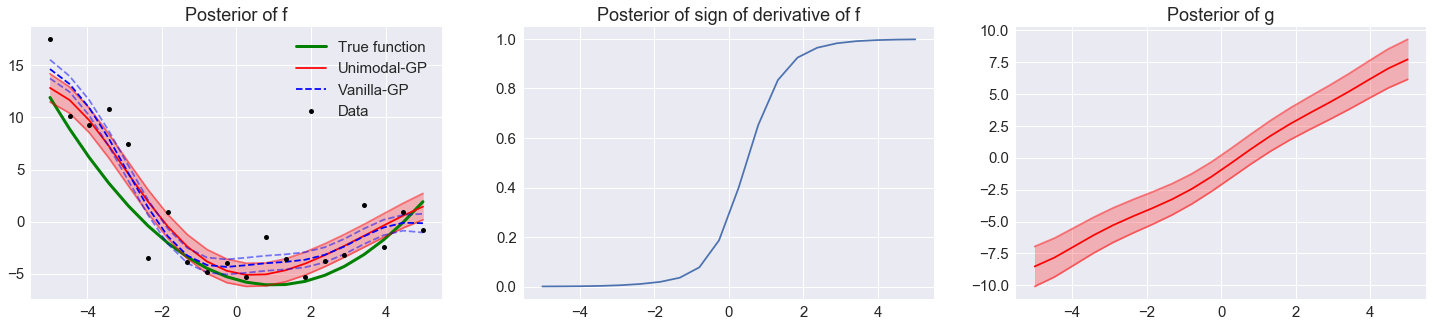

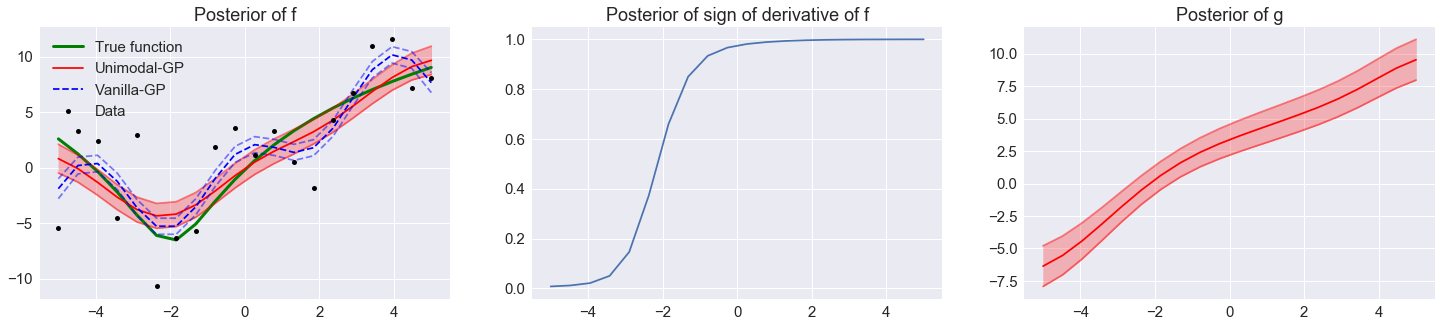

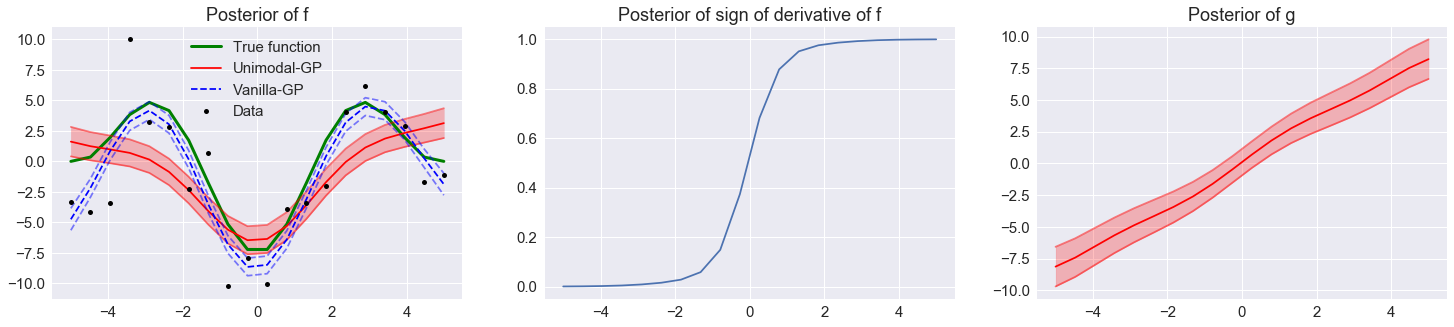

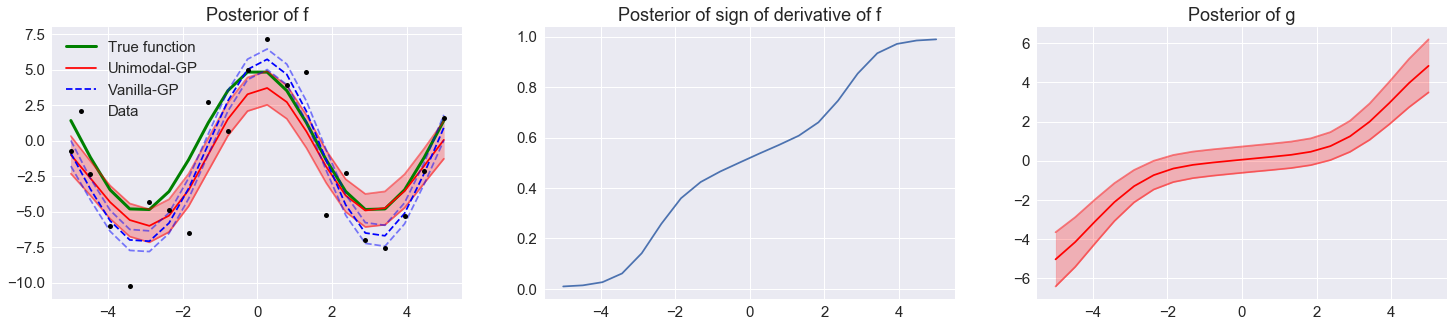

In [6]:
for idx in range(len(ys)):
    f, y = fs[idx](t), ys[idx]

    mu_f, Sigma_f, mu_g, Sigma_g = ep_unimodality(t, y, t2)
    model = GPy.models.GPRegression(X=t, Y=y, kernel=GPy.kern.RBF(input_dim=1, lengthscale=k2, variance=k1**2))
    mu_gpy, sigma_gpy = model.predict(Xnew=t,include_likelihood=False)

    plt.figure(figsize = (25, 5))
    plt.subplot(1, 3, 1)
    plt.plot(t, f, 'g-', linewidth = 3., label='True function')
    plot_with_uncertainty(x=t, y=mu_f[:N], ystd=np.sqrt(Sigma_f[:N]), label='Unimodal-GP')
    plot_with_uncertainty(x=t, y=mu_gpy, ystd=np.sqrt(sigma_gpy), color='b', fill=False, linestyle='--', label = 'Vanilla-GP')
    plt.plot(t, y, 'k.', markersize=10, label='Data')
    plt.title('Posterior of f')
    plt.legend()

    plt.subplot(1, 3, 2)
    pz = phi(mu_g[:M]/np.sqrt(1 + Sigma_g[:M]))
    plt.plot(t2, pz)
    plt.title('Posterior of sign of derivative of f')

    plt.subplot(1, 3, 3)
    plot_with_uncertainty(x=t2, y=mu_g[:M], ystd=np.sqrt(Sigma_g[:M]))
    plt.title('Posterior of g')